# 数据分析

In [1]:
import os
import django

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "SciNewsSite.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()
from blog.models import Blog, Word
from matplotlib import pyplot as plt
from django.db.models import Q
import numpy as np
import pandas as pd
import datetime

## 不同主题关注度分析
我们以月为单位，可视化关于科技产品、人工智能、科技财经方面的新闻条目占比变化。通过观察新闻条目的变化，能够推断出社会对不同主题新闻的关注度随时间的变化。
经统计，新闻最早为2022-04-11 21:41:04， 最晚为2023-08-25 20:59:26， 共计17个月

In [2]:
date_ls = [(2022, 4), (2022, 5), (2022, 6), (2022, 7), (2022, 8), (2022, 9), (2022, 10), (2022, 11), (2022, 12),
           (2023, 1), (2023, 2), (2023, 3), (2023, 4), (2023, 5), (2023, 6), (2023, 7), (2023, 8), (2023, 9)]
product_arr = np.zeros(len(date_ls) - 1, dtype=np.float32)
ai_arr = np.zeros(len(date_ls) - 1, dtype=np.float32)
finance_arr = np.zeros(len(date_ls) - 1, dtype=np.float32)
chatgpt_arr = np.zeros(len(date_ls) - 1, dtype=np.float32)
chatgpt_words = Word.objects.filter(Q(word__iexact='chatgpt') | Q(word='大模型'))
chatgpt_blogs = []
for word in chatgpt_words:
    chatgpt_blogs.extend([int(blog) for blog in word.blogs.split(',')])
chatgpt_blogs = set(chatgpt_blogs)
# 按月计算比例
for i in range(len(date_ls) - 1):
    date_start = datetime.datetime(date_ls[i][0], date_ls[i][1], 1, 0, 0, 0)
    date_end = datetime.datetime(date_ls[i + 1][0], date_ls[i + 1][1], 1, 0, 0, 0)
    blog_ls = Blog.objects.filter(create_time__gte=date_start, create_time__lt=date_end)
    product_arr[i] = blog_ls.filter(theme='科技产品').count() / blog_ls.count()
    ai_arr[i] = blog_ls.filter(theme='AI').count() / blog_ls.count()
    finance_arr[i] = blog_ls.filter(theme='财经').count() / blog_ls.count()
    chatgpt_arr[i] = blog_ls.filter(id__in=chatgpt_blogs).count() / blog_ls.count()

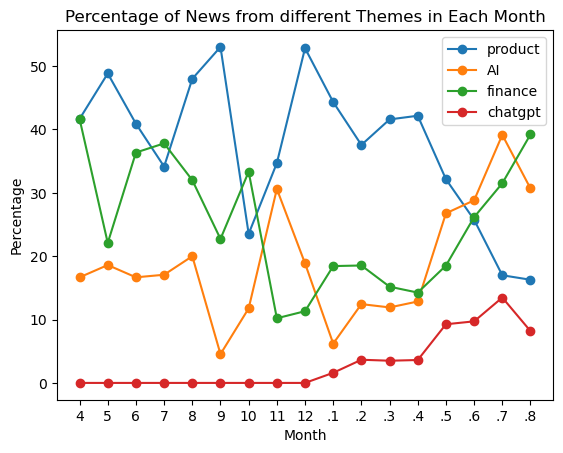

In [3]:
# 绘制折线图
x = ["4", "5", "6", "7", "8", "9", "10", "11", "12", ".1", ".2",
     ".3"
    , ".4", ".5", ".6", ".7", ".8"]
plt.plot(x, product_arr * 100, label='product', marker='o')
plt.plot(x, ai_arr * 100, label='AI', marker='o')
plt.plot(x, finance_arr * 100, label='finance', marker='o')
plt.plot(x, chatgpt_arr * 100, label='chatgpt', marker='o')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('Percentage of News from different Themes in Each Month')
plt.legend()
plt.show()

图中，横轴为月份，分别为2022年4月到2023年8月。纵轴为各主题的新闻占比。经过分析，可以得出以下结论：
1.AI主题新闻占比总体呈上升趋势，科技产品类新闻占比总体呈下降趋势。这一现象在2023年1月之后越发明显。结合ChatGPT占比从2023年1月开始稳步上升的现象，可以推断这两个主题新闻占比的变化趋势很可能与ChatGPT的爆火有关。
2.财经类新闻占比曲线总体为“U”型。与2022年疫情期间科技企业金融情况不景气有关。2023年1月之后稳步提升，推断与ChatGPT带来的大模型投资潮有关。

## 词云图

In [4]:
stopwords = []  # 停用词
with open('stopwords.txt', 'r') as s_f:
    stopwords.extend(s_f.read().split('\n'))
stopwords.extend([' ', '\n', '\t'])

words_df = pd.read_csv('keywords.csv').astype(str)  # 载入预先提取好的关键词
kw_ls = words_df[~words_df['kw'].isin(stopwords)]  # 滤去停用词

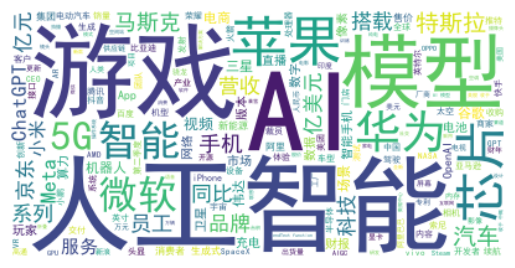

In [5]:
from wordcloud import WordCloud

wc = WordCloud(font_path=r"C:\Windows\Fonts\simhei.ttf",  # 字体
               background_color='white',  # 背景颜色
               max_words=1000)  # 词云显示的最大词数
wc.generate(' '.join(kw_ls['kw'].tolist()))
#show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

通过绘制词云图，我们发现，科技新闻的关键词中，“人工智能”“AI”“模型”“智能”占大多数，这与近些年的人工智能热潮高度一致。接着是“游戏，透露出当今媒体向适应年轻人的消费爱好与兴趣的方向转型。”紧随其后的是“芯片”，也反映了我国媒体及民众对于我国卡脖子问题的关注与解决这一问题的期待。“苹果”“华为”“微软”等公司名称紧随其后，反映了不同国家科技企业的发展情况。频率再小一些的便是最近的科技热词，像是“5G”“ChatGPT”等。

## 聚类

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.manifold import TSNE
from matplotlib.font_manager import FontProperties
import gensim
import jieba.analyse

In [7]:
word_ls = []
for blog in Blog.objects.all():
    text = blog.text
    temp_ls = []
    # 与词云图不同，这次每个文章提取5个关键词
    tags = jieba.analyse.extract_tags(text, topK=5, withWeight=True)
    for word, weight in tags:
        if word not in stopwords:  # 滤除停用词
            temp_ls.append(word)
    word_ls.append(temp_ls)
print(word_ls[:5])  # 打印前5条

Building prefix dict from the default dictionary ...
Loading model from cache C:\Temp\jieba.cache
Loading model cost 0.444 seconds.
Prefix dict has been built successfully.


[['数智化', 'BIP', '服务', '最新版'], ['Schmidhuber', '模型', 'Meta', 'LeCun', 'Llama2'], ['华为', '北斗', 'P60', '系列', '双向'], ['华为', '许可', '网联', '续签'], ['苹果', '员工', 'CWA', '工会', '门店']]


In [8]:
gensim_model = gensim.models.Word2Vec(word_ls, min_count=30)  # 转化为词向量
words = list(gensim_model.wv.key_to_index)  # 存储标签
words[:5]  # 打印前5条

['AI', '人工智能', '模型', '游戏', '苹果']

In [9]:
# 统计词频
from collections import defaultdict

frequency_dic = defaultdict(int)
for sub_ls in word_ls:
    for word in sub_ls:
        frequency_dic[word] += 1  # 首先建立所有词频的字典
words = list(set(words))
frequency = [frequency_dic[word] for word in words]  # 抽取words对应的词频
frequency_df = pd.DataFrame({'kw': words, 'frequency': frequency})
frequency_df # 同样打印前五条

,kw,frequency
0,驾驶,59
1,京东,119
2,华为,185
3,App,40
4,汽车,136
...,...,...
129,阿里巴巴,35
130,显卡,37
131,推特,88
132,电动汽车,44


In [10]:
# 利用T-SNE降维
tsne_model = TSNE(n_components=2, random_state=0)
tsne_result = tsne_model.fit_transform(gensim_model.wv[words])

(134, 2)
(134, 2)


194

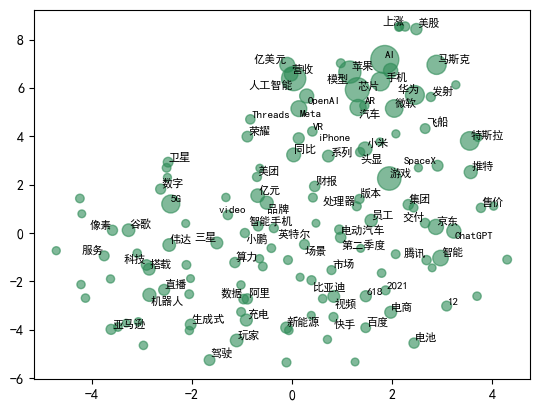

In [11]:
from adjustText import adjust_text

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
print(tsne_result.shape)
print(frequency_df.shape)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=frequency, alpha=0.6)
# 使用adjustText避免文本重叠
new_texts = [plt.text(x, y, word, fontsize=8) for x, y, word in zip(tsne_result[:, 0], tsne_result[:, 1], words) if
             frequency_dic[word] > 40]  # 过滤一部分标签
adjust_text(new_texts)

D:\anaconda\envs\django\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\envs\django\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\envs\django\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\envs\django\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows wi

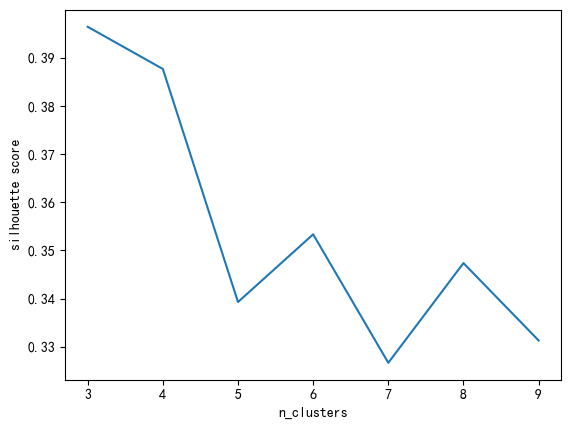

In [12]:
# 首先找出最优类别数
silhouette_score_ls = []  # 平均轮廓系数
for i in range(3, 10):
    model = (KMeans(n_clusters=i, random_state=0, n_init='auto'))
    result = model.fit(tsne_result)
    silhouette_score_ls.append(silhouette_score(tsne_result, model.labels_))
plt.plot(range(3, 10), silhouette_score_ls)
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')
plt.show()

In [15]:
kmeans_model = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(tsne_result)

D:\anaconda\envs\django\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


85

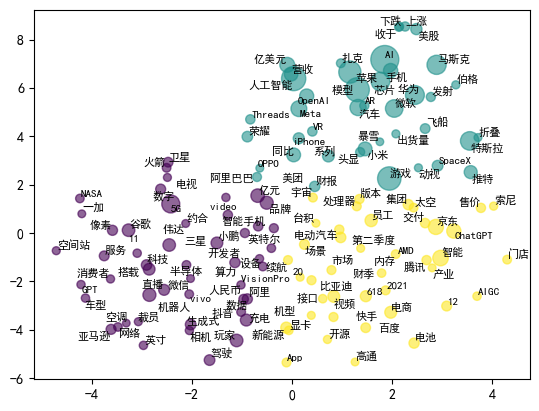

In [16]:
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_model.labels_, s=frequency, alpha=0.6)
# 使用adjustText避免文本重叠
new_texts = [plt.text(x, y, word, fontsize=8) for x, y, word in zip(tsne_result[:, 0], tsne_result[:, 1], words) if
             frequency_dic[word] > 20]  # 过滤一部分标签
adjust_text(new_texts)

聚类过程中尝试了多种参数组合，但效果都一般，散点的分布比较均匀，并没有明显的聚类，表示近期国内科技新闻同质化现象比较严重。上图分类中，蓝色是近期热度比较高的关键词，而“华为”与“芯片”距离较近充分反映媒体对于华为能否打赢芯片战的关注，“马斯克”与“SpaceX”,”特斯拉“距离较近也充分表明大家对于科技创新的关注。黄色分类与粉色分类偏向于产品、销售层面，例如电器方面的”相机“”电视“”空调“”门店“”电池“等距离较近，硬件方面的“英特尔””处理器“”显卡“距离较近。（注，再次运行可能导致分类颜色发生变化）